# All

In [42]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

train_dataset = torchvision.datasets.MNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)]))

test_dataset = torchvision.datasets.MNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)]))
from torch.utils.data import random_split, Dataset, DataLoader

## Train-val split
train_set, val_set = random_split(train_dataset, [50000, 10000])

print(f"Size of the training set: {len(train_set)}")
print(f"Size of the validation set: {len(val_set)}")
print(f"Size of the test set: {len(test_dataset)}")

## Create the data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


In [43]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()


        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(True),
            nn.Linear(500, 100),
            nn.ReLU(True),
            nn.Linear(100, encoded_space_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 100),
            nn.ReLU(True),
            nn.Linear(100, 500),
            nn.ReLU(True),
            nn.Linear(500, 784),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )


    def forward(self, x):
        x = self.decoder_lin(x)
        x = torch.sigmoid(x)
        return x

In [44]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 30

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=748)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=748)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

In [45]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [46]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [47]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/15 	 train loss 0.06269179284572601 	 val loss 0.03625420853495598


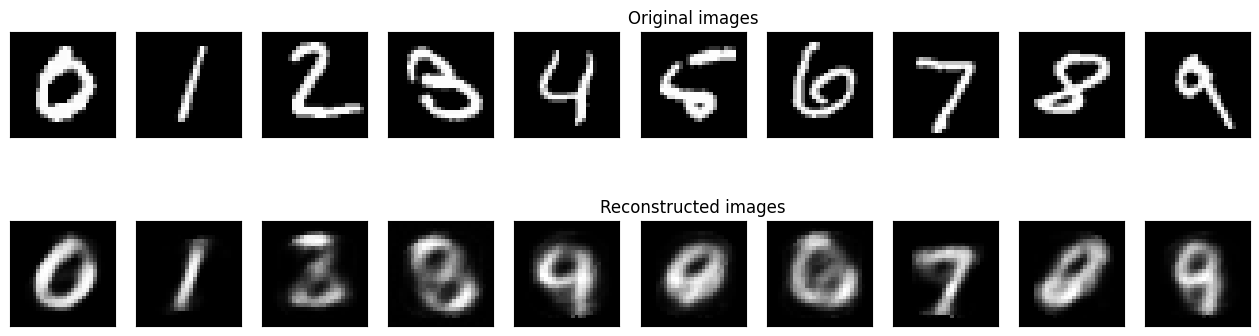


 EPOCH 2/15 	 train loss 0.03155535086989403 	 val loss 0.027112701907753944


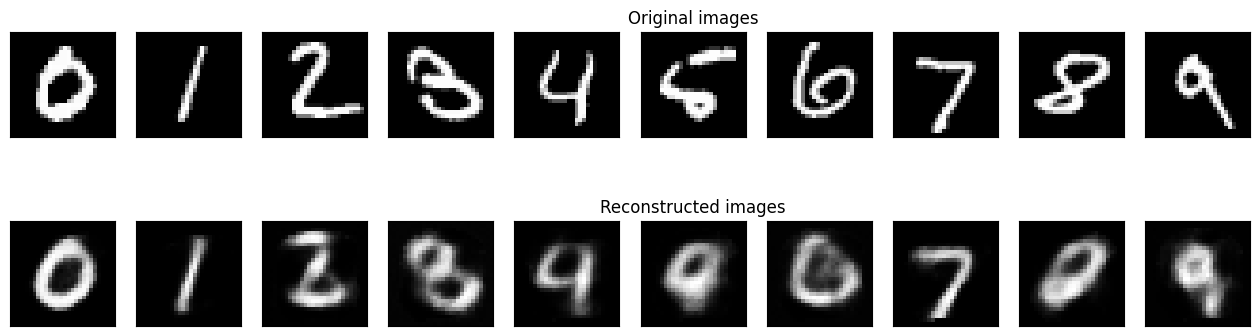


 EPOCH 3/15 	 train loss 0.025629814714193344 	 val loss 0.02366175688803196


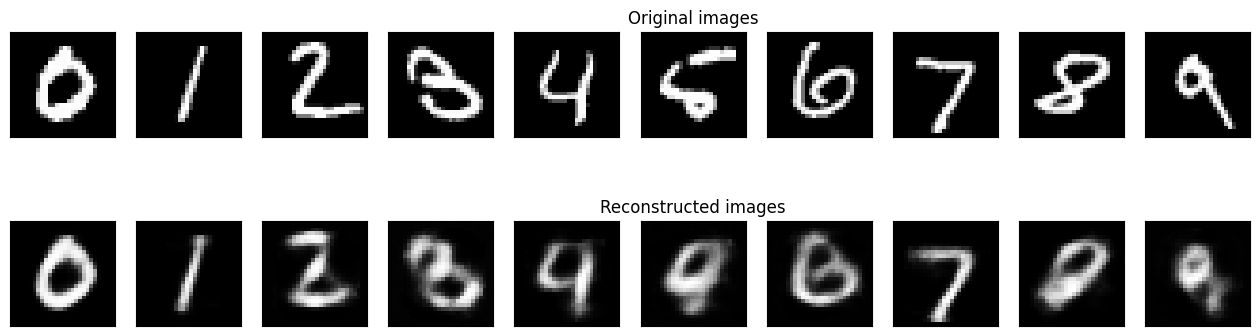


 EPOCH 4/15 	 train loss 0.022404374554753304 	 val loss 0.02120610512793064


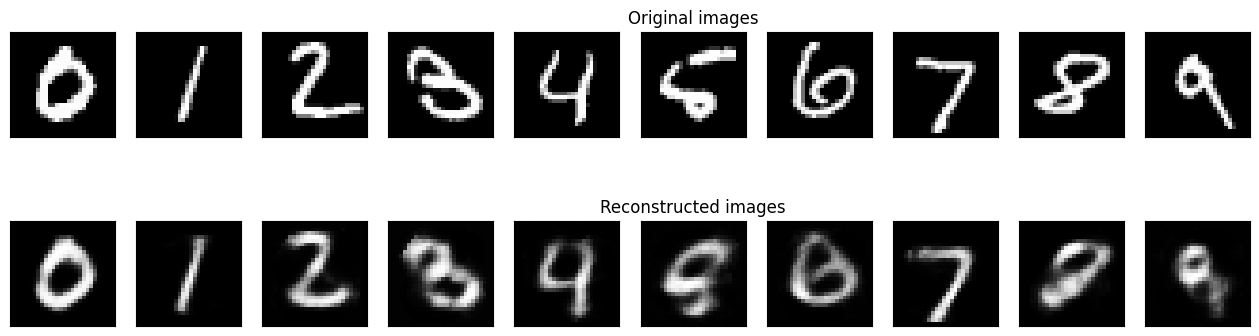


 EPOCH 5/15 	 train loss 0.020115926861763 	 val loss 0.018889034166932106


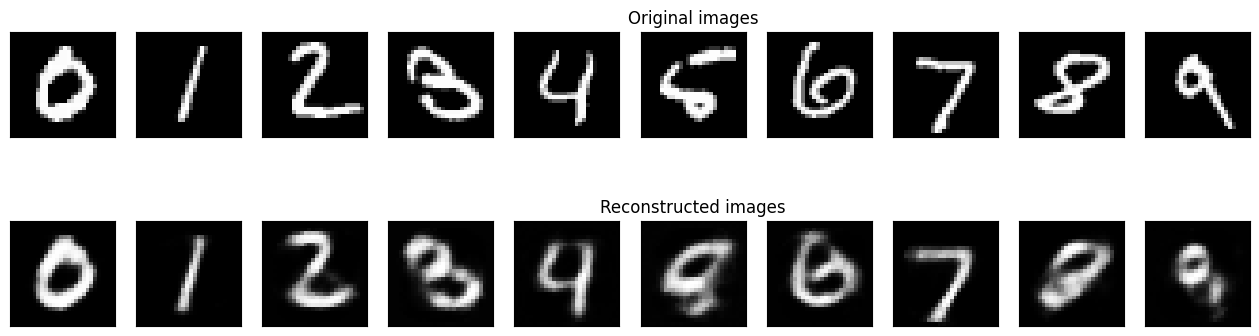


 EPOCH 6/15 	 train loss 0.01852252334356308 	 val loss 0.017505204305052757


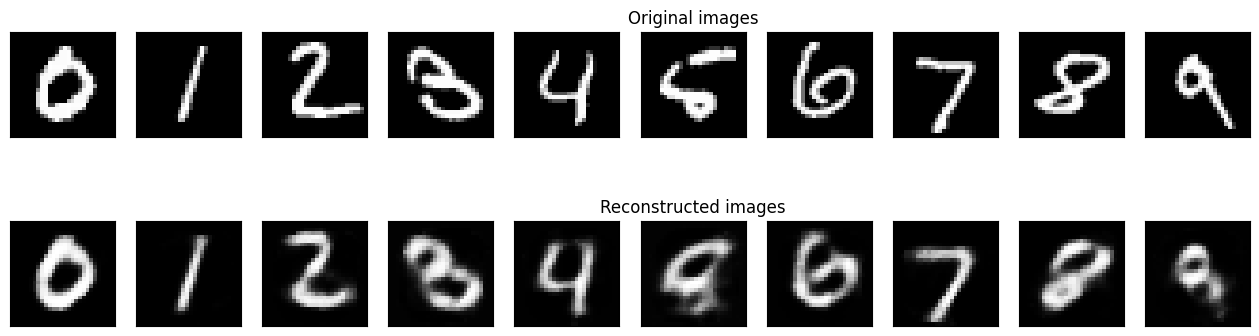


 EPOCH 7/15 	 train loss 0.017200319096446037 	 val loss 0.01636791042983532


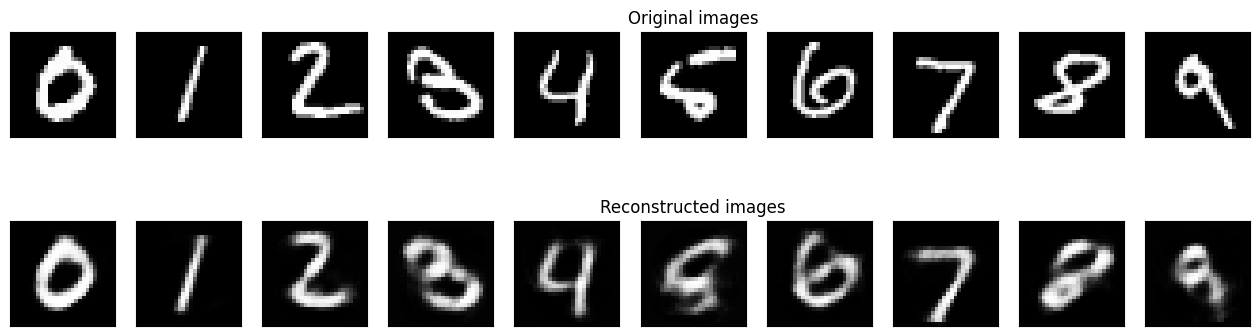


 EPOCH 8/15 	 train loss 0.016245795413851738 	 val loss 0.015633873641490936


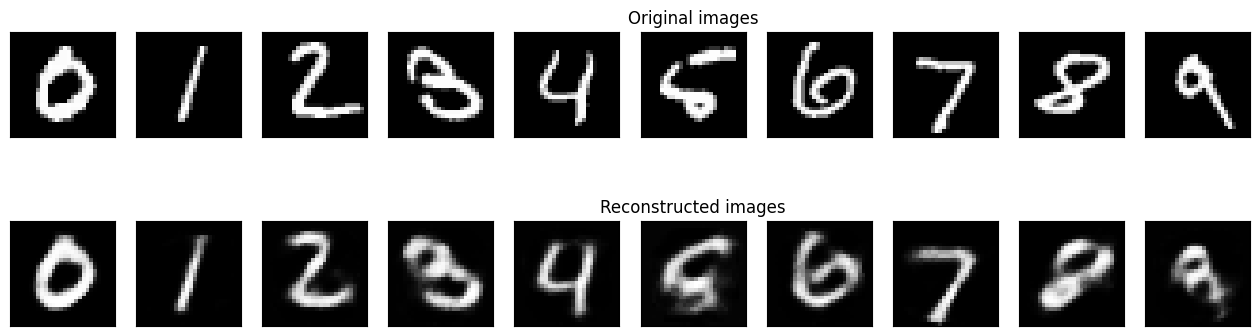


 EPOCH 9/15 	 train loss 0.015484987758100033 	 val loss 0.014770948328077793


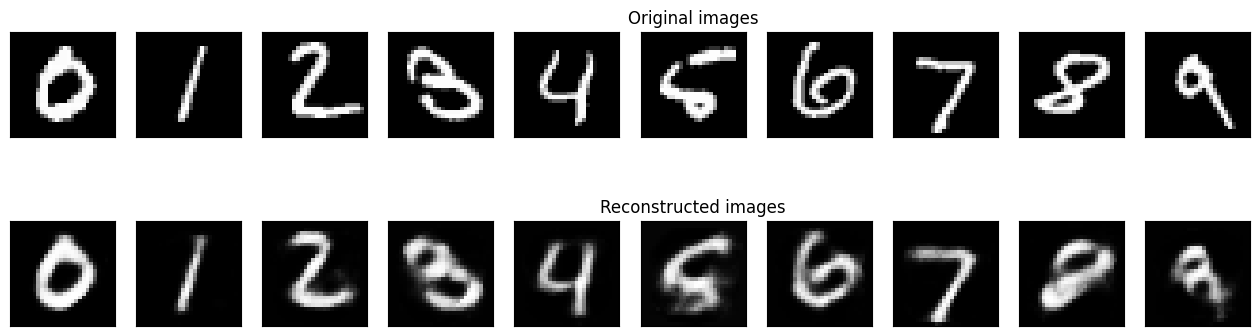


 EPOCH 10/15 	 train loss 0.01482961606234312 	 val loss 0.014431210234761238


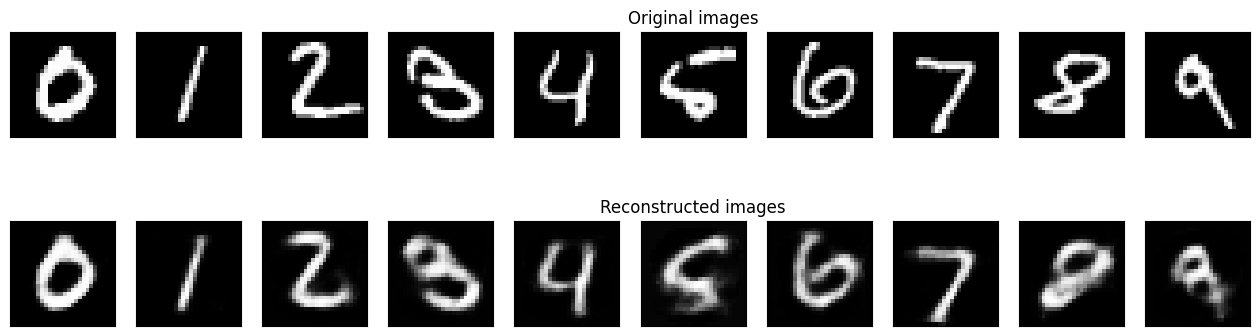


 EPOCH 11/15 	 train loss 0.014331587590277195 	 val loss 0.013887015171349049


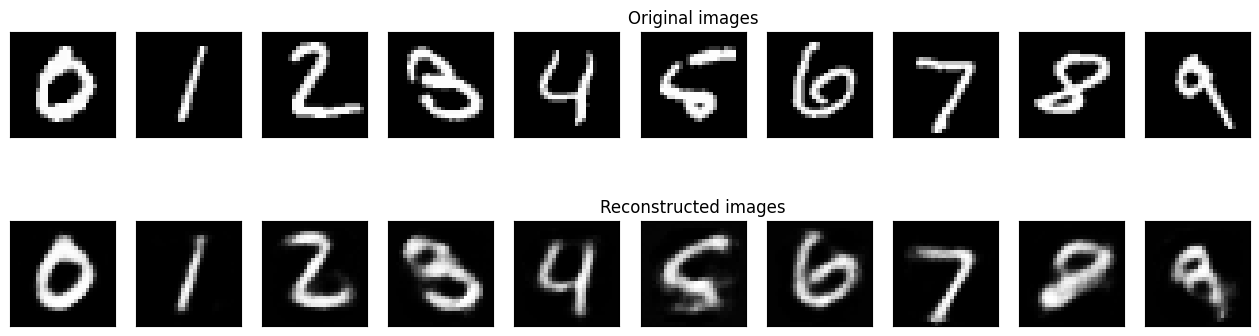


 EPOCH 12/15 	 train loss 0.013894470408558846 	 val loss 0.013669049367308617


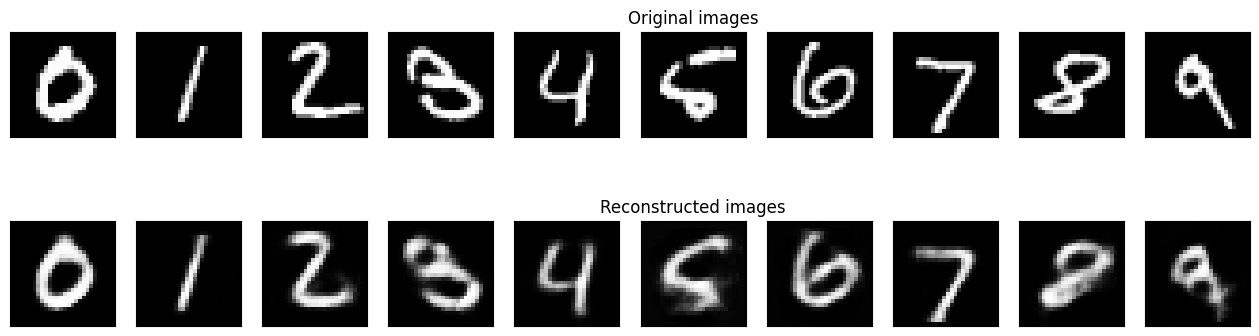


 EPOCH 13/15 	 train loss 0.013475045561790466 	 val loss 0.013076764531433582


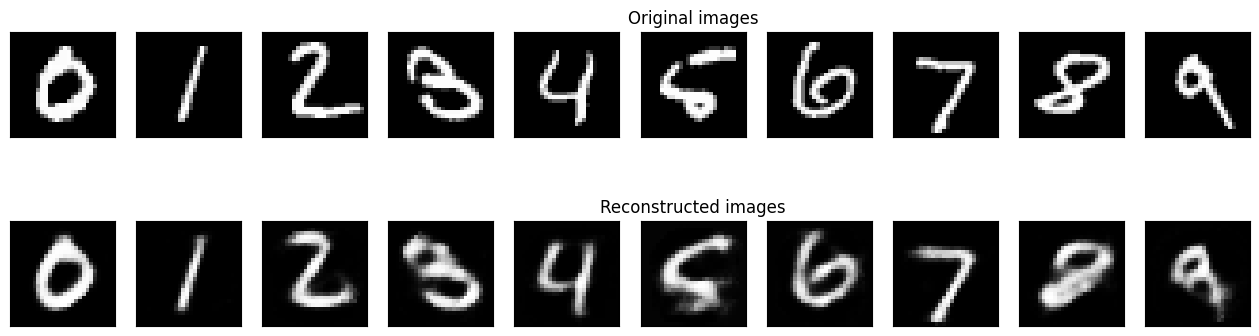


 EPOCH 14/15 	 train loss 0.013082567602396011 	 val loss 0.012675028294324875


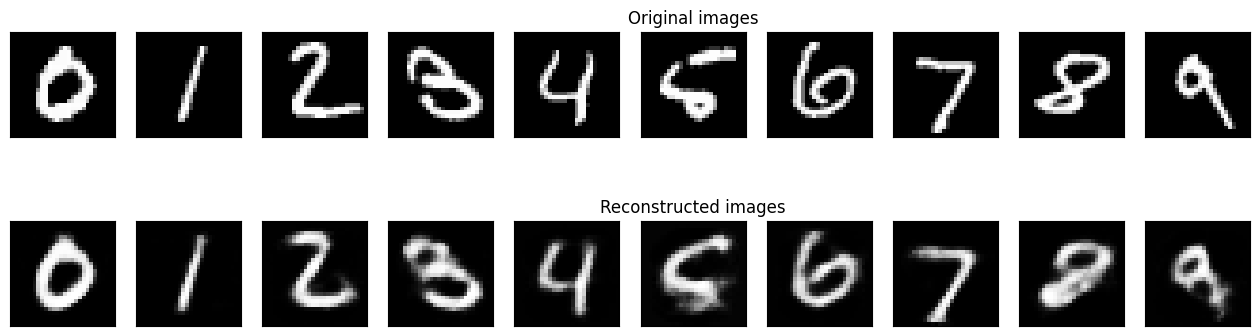


 EPOCH 15/15 	 train loss 0.012777484953403473 	 val loss 0.01252400130033493


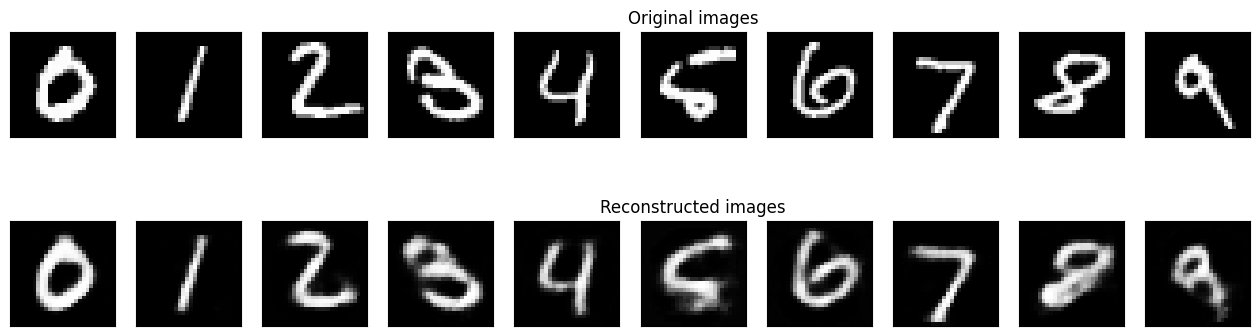

In [48]:
num_epochs = 15
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)